# Projet numérique de Science des Données 2025

__Binôme numéro 60 -- BENDALI Ilias et COUTURIER Julien__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

L'intérêt est tout d'abord économique : cela permet une détection de personnes à risques sans avoir à voir chaque personne.
Le soucis étant que cela enlève un côté social dans ces zones entre les habitants et les médecins. En plus de cela, les algorithmes développés ci-dessous sont bien moins précis qu'une étude médicale sérieuse

## Librairies usuelles

In [45]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [46]:
df_train = pd.read_csv('data/donnees_entrainement.csv')
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [47]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')
X_train

array([[ 21. ,  85. ,  55. ,   7. ,  36.2,  84. ],
       [ 36. , 145. , 100. ,   6.9,  39.5,  73. ],
       [ 15.5, 120. ,  75. ,   7.4,  39. ,  74. ],
       ...,
       [ 53.5, 100. ,  70. ,   7.7,  36.2,  68. ],
       [ 18.5, 120. ,  70. ,   7.5,  37.1,  69. ],
       [ 21.5, 100. ,  90. ,   6.8,  37.3,  66. ]])

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

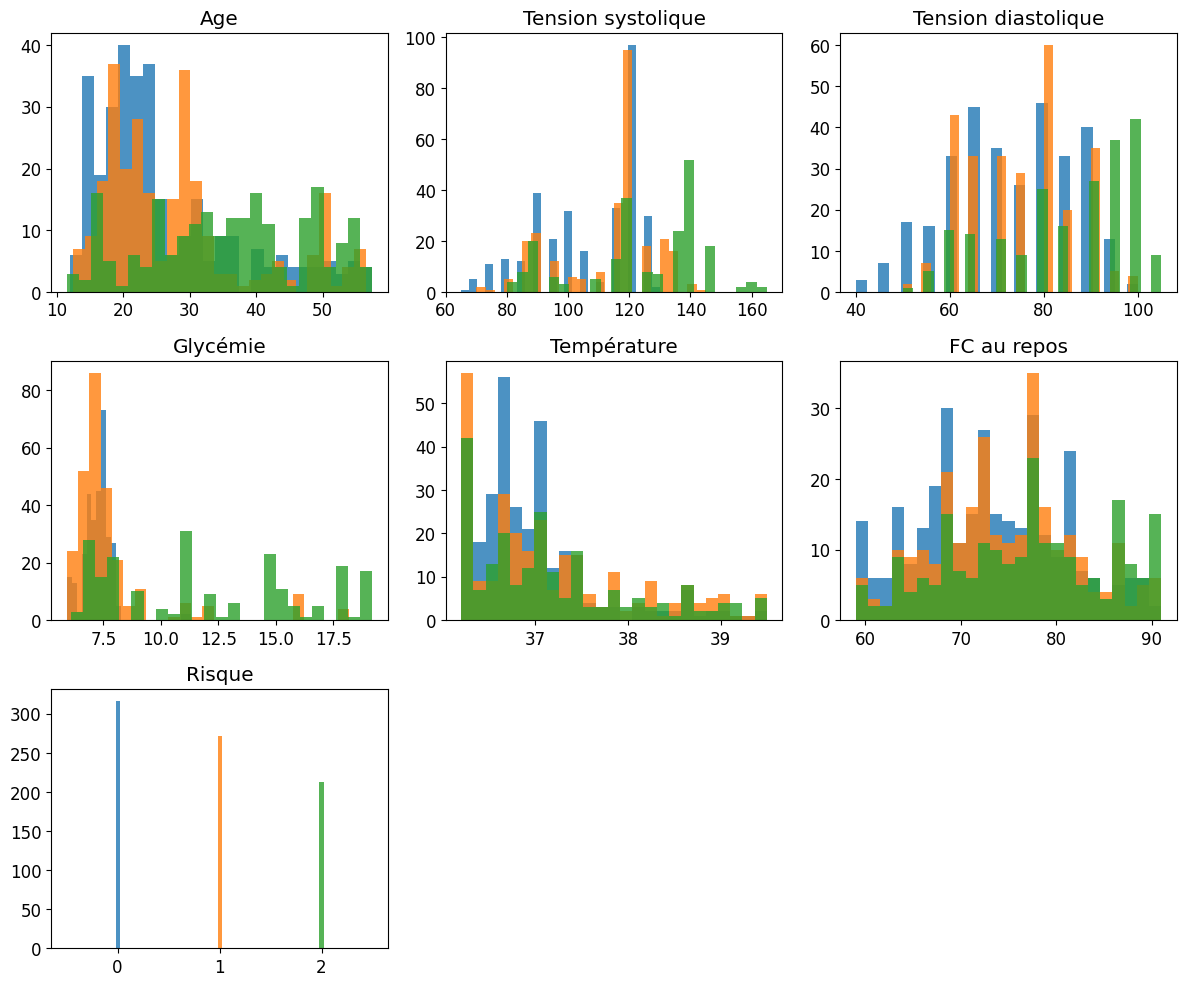

In [48]:
fig = plt.figure(figsize=(12, 10))

# Histogrammes pour les variables continues
for (feat_idx, feat_name) in enumerate(df_train[:-1]):

    ax = fig.add_subplot(3, 3, (feat_idx+1))

    for risque in range(3):

        # afficher l'histogramme de la variable feat_name
        h = ax.hist(df_train[df_train['Risque']==risque][feat_name], bins=25, alpha=0.8 ,edgecolor='none')

        # utiliser le nom de la variable comme titre pour chaque histogramme
        ax.set_title(feat_name)
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

On voit que le risque augmente avec la fréquence cardiaque, l'âge et les tensions systolique et diastolique ce qui semble tout à fait logique. 
De plus, les plages de fréquences cardiaques, de glycémie et d etempératures corporelles semblent tout à fait usuelles. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Cela semble plutôt difficile étant donné qu'il n'y a pas une différence considérable au niveau des profils étudiés. Il semble plutôt simple de distinguer les classes 'personnes ayant un risque égal à 2" et " personnes ayant un risque nul ou égal à 1". En revanche, cela semble plus compliqué de distinguer les risques égaux à 0 et à 1.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

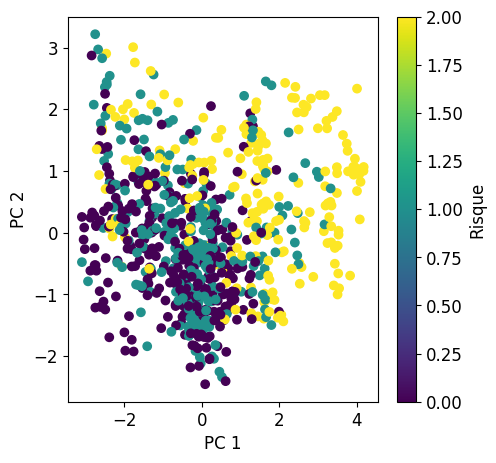

In [49]:
# On va commencer par centrer réduire les différentes variables comme lors de la PC3. 
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)

# On calcule ensuite les projections sur les deux composantes principales
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_projected = pca.transform(X_train_scaled)

# On les affiche ensuite 
fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df_train['Risque'])

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Risque')



### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

On arrive légèrement (difficilement) à distinguer les risques élevés des risques valant 0 ou 1. Il n'y a pas de distinction entre les classes "risque valant 1" et "risque valant 0". Ainsi, utiliser une ACP semble plutôt difficile pour obtenir un prédicteur fiable.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les différentes données')

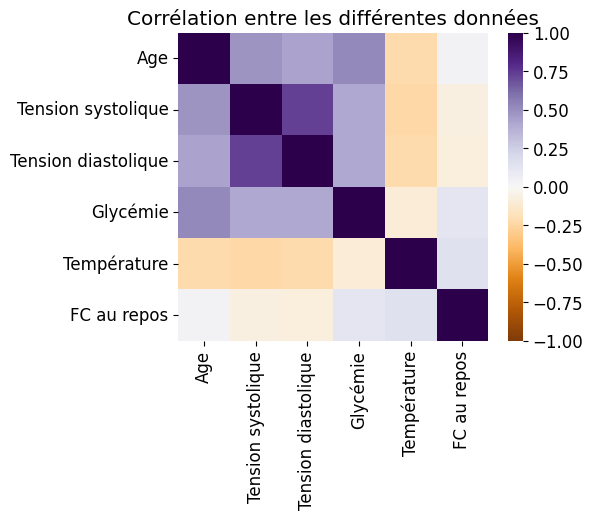

In [50]:
# Ici, on peut utiliser panda pour calculer les valeurs et seaborn pour obtenir la heatmap (comme lors de la PC3)

import seaborn as sns

# Calcul de la matrice de corrélation deux à deux (en enlevant l'étiquette donc le risque)
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les différentes données")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

On voit dessus que 2 variables semblent très correlées : tension systolique et diastolique. Ainsi, réduire la dimension d'un rang semble être une bonne idée.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [51]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

x_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk.drop(columns=['Risque']))



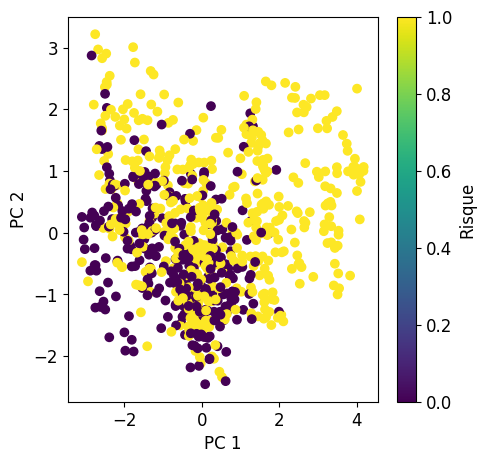

In [52]:
# Pour nous rendre compte de ce que cela changera sur notre nuage de points, on peut retracer le nuage de points de la question 5 
# en adaptant pour les nouvelles valeurs de risques : 

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df_train_risk_vs_norisk['Risque'])

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Risque')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

Cela revient à calculer la proportion de la classe majoritaire dans l'échantillon observé

In [53]:
a = df_train_risk_vs_norisk['Risque'].value_counts()
accuracy = a[1]/(a[1]+a[0]) # il y a a[1] = 484 personnes ayant un risque égal à 1 (majoritaire ici)
print("accuracy =", accuracy)


accuracy = 0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Ici, on a la moyenne entre "les tests positifs détectés parmi les vrais positifs" et "les tests négatifs détectéss parmi les vrais négatifs". Cet indicateur est bien plus précis que l'accuracy car il prend en compte toutes les données là où l'accuracy ne prend pas en compte les faux négatifs pour notre exemple car minoritaire. 
Ainsi, utiliser l'accuracy pour un test étant mauvais pour détecter les positifs mais bon pour détecter les négatifs sur un échantillon contenant plus de négatifs que de positifs serait dramatique pour notre étude.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

La phase d'entrainement d'un classifieur tel que le KNN consiste à stocker et mémoriser les données d'entraînement : les entrées ainsi que les valeurs cibles.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

On s'attend à une précision équilibrée égale à 1 sur le jeu d'entraînement. En effet, pour chaque test, le plus proche voisin est le point lui-même (de distance nulle) ! Ainsi, toutes les étiquettes sont bien attribuées.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [54]:
from sklearn import model_selection, metrics
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)

print (metrics.balanced_accuracy_score(y_train,y_pred))



1.0


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

L'algorithme faisant intervenir des calculs de distance et les variables étant étalées sur des échelles différentes : il faut donc centrer et réduire chaque variable

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [55]:
std_scale = preprocessing.StandardScaler().fit(x_train_risk_vs_norisk)
X_train_risk_vs_norisk_scaled = std_scale.transform(x_train_risk_vs_norisk)

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=30)
k_list = [int(i) for i in range(1,50)]
knn=KNeighborsClassifier()
grid = model_selection.GridSearchCV(knn, {'n_neighbors':k_list}, 
                                    cv=kf,
                                    scoring='balanced_accuracy'
                                   )

grid.fit(X_train_risk_vs_norisk_scaled,y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=30, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='balanced_accuracy')

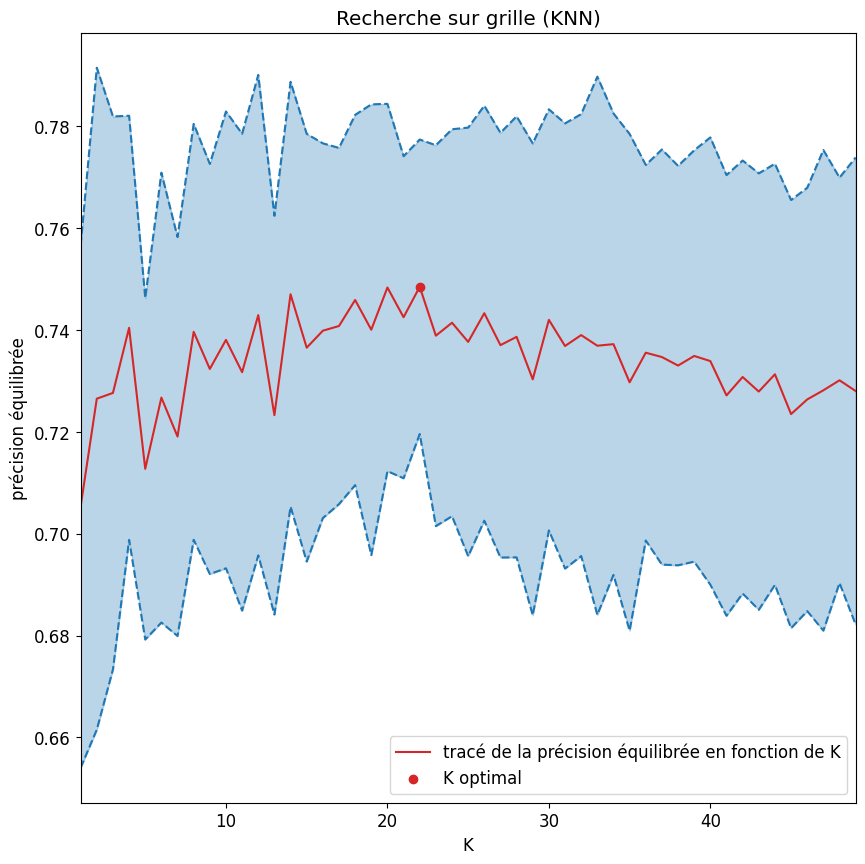

In [56]:
plt.figure(figsize=(10, 10))

bal_acc_scores = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.plot(grid.cv_results_['param_n_neighbors'], bal_acc_scores, 
             label="tracé de la précision équilibrée en fonction de K", color='tab:red')
plt.plot(grid.cv_results_['param_n_neighbors'], bal_acc_scores + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], bal_acc_scores - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(k_list, (bal_acc_scores+ std_error), (bal_acc_scores - std_error), 
                 color='tab:blue',
                 alpha=0.3
                )

plt.scatter(grid.best_params_['n_neighbors'], grid.best_score_, color='tab:red', label="K optimal")

plt.xlabel("K")
plt.ylabel("précision équilibrée")
plt.xlim([k_list[0], k_list[-1]])
plt.title("Recherche sur grille (KNN)")
plt.legend(loc='best')

In [57]:
print(f'La meilleure valeur de K est {grid.best_params_['n_neighbors']} avec une précision équilibrée de {grid.best_score_:.2f}')

La meilleure valeur de K est 22 avec une précision équilibrée de 0.75


On voit sur ce graphique des sortes d'oscillations selon les valeurs de K. La majorité des points semblent être dans la même plage de valeur de précision équilibrée (0.71 - 0.75) donc globalement on voit que notre algorithme e choix de K n'importante pas tant. 

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [58]:
from sklearn import model_selection
from sklearn import linear_model

Ici, puisqu'il n'y a pas de présumé risque de sur apprentissage (ou du moins, on ne sait toujours pas), on effectue une régression ridge (l2). Sinon, on effectuerait une régression lasso pour faire tomber des coefficients à 0 afin de décomplexifier le modèle obtenu et de sélectionner les variables.

La meilleure valeur du coefficient de régularisation est 0.20565 avec une précision équilibrée de 0.61


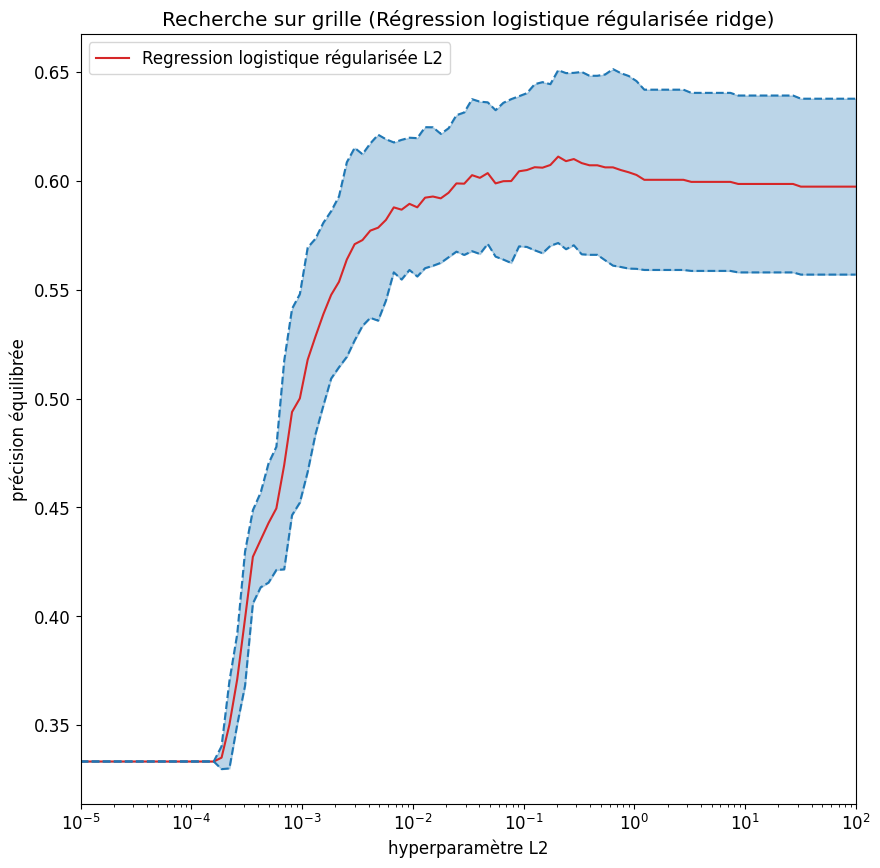

In [59]:
coeffs = np.logspace(-5, 2, 100)

logreg=linear_model.LogisticRegression(max_iter=1000) # par défaut, penalty = l2

grid = model_selection.GridSearchCV(logreg, {'C':coeffs}, 
                                    cv=kf,
                                    scoring='balanced_accuracy'
                                   )

grid.fit(X_train_risk_vs_norisk_scaled,y_train)

plt.figure(figsize=(10, 10))

bal_acc_scores = grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.semilogx(grid.cv_results_['param_C'], bal_acc_scores, 
             label="Regression logistique régularisée L2", color='tab:red')
plt.semilogx(grid.cv_results_['param_C'], bal_acc_scores + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_C'], bal_acc_scores - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(coeffs, (bal_acc_scores+ std_error), (bal_acc_scores - std_error), 
                 color='tab:blue',
                 alpha=0.3
                )

# Mise en forme
plt.xlabel("hyperparamètre L2")
plt.ylabel("précision équilibrée")
plt.xlim([coeffs[0], coeffs[-1]])
plt.title("Recherche sur grille (Régression logistique régularisée ridge)")
plt.legend(loc='best')
print(f'La meilleure valeur du coefficient de régularisation est {grid.best_params_['C']:.5f} avec une précision équilibrée de {grid.best_score_:.2f}')

On voit ici que la précision équilibrée augmente avec le coefficient de la régularisation jusqu'à atteindre un plafond au-delà duquel le modèle n'apprend plus.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

Ici, nous faisons le choix d'utiliser un algorithme de forêt aléatoire car il semble être un bon compromis entre temps de calculs lors de la phase d'entraînement et de taille de jeu d'netraînement. (aussi, je n'avais pas très bien compris son fonctionnement avec le poly donc c'était un moyen de me pencher dessus).
L'hyperparamètre à optimiser est donc le nombre d'arbres !

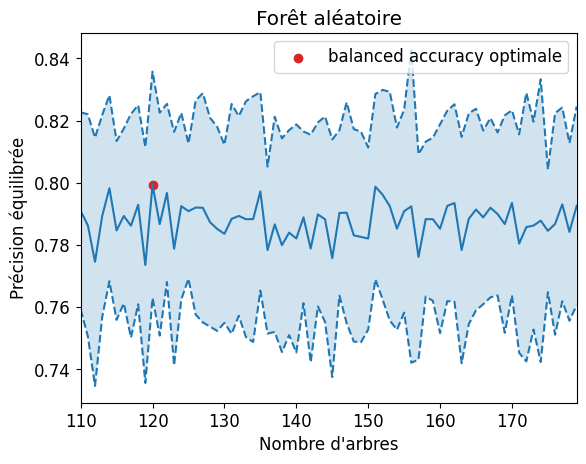

In [60]:
# en utilisant la doc sur la forêt aléatoire :

from sklearn import ensemble
n_trees = np.arange(110, 180, 1)
forest=ensemble.RandomForestClassifier()
grid_forest=model_selection.GridSearchCV(forest, {'n_estimators' : n_trees}, cv=5, scoring = 'balanced_accuracy')

grid_forest.fit(X_train_risk_vs_norisk_scaled, y_train_risk_vs_norisk)

balanced_accuracy = grid_forest.cv_results_['mean_test_score']
std_error = grid_forest.cv_results_['std_test_score']

plt.plot(grid_forest.cv_results_['param_n_estimators'], balanced_accuracy, 
             label="", color='tab:blue')
plt.plot(grid_forest.cv_results_['param_n_estimators'], balanced_accuracy + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_forest.cv_results_['param_n_estimators'], balanced_accuracy - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_forest.cv_results_['param_n_estimators'], (balanced_accuracy + std_error), (balanced_accuracy - std_error), 
                 alpha=0.2 # contrôle la transparence
                )
plt.scatter(grid_forest.best_params_['n_estimators'], grid_forest.best_score_, 
           color='tab:red', label='balanced accuracy optimale')

plt.xlabel("Nombre d'arbres")
plt.ylabel("Précision équilibrée")
plt.xlim([n_trees[0], n_trees[-1]])
plt.title("Forêt aléatoire")
plt.legend(loc='best')

In [61]:
print(f"Le meilleur nombre d'arbres est : {grid_forest.best_params_['n_estimators']}")
print(f"La valeur de précision équilibrée correspondante est : {grid_forest.best_score_:.2f}")

Le meilleur nombre d'arbres est : 120
La valeur de précision équilibrée correspondante est : 0.80


Tout comme pour le KNN, on observe ici que le nombre d'arbres n'a finalement pas tant d'importance étant donné la courbe. La précision équilibrée observée ici semble bien meilleure que celle du KNN

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

C'est la forêt aléatoire avec une précision équilibrée de 0.80 .

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

On a vu précédemment que réduire à 5 variables semble être approprié, nous verrons ensuite avec le calcul de variance expliquée que cela est vrai.

In [62]:
pca_bis = decomposition.PCA(n_components=5)
pca_bis.fit(X_train_scaled)
X_projected = pca_bis.transform(X_train_scaled)
print(X_projected.shape)

(800, 5)


Text(0.5, 1.0, 'Proportion cumulative de variance expliquée')

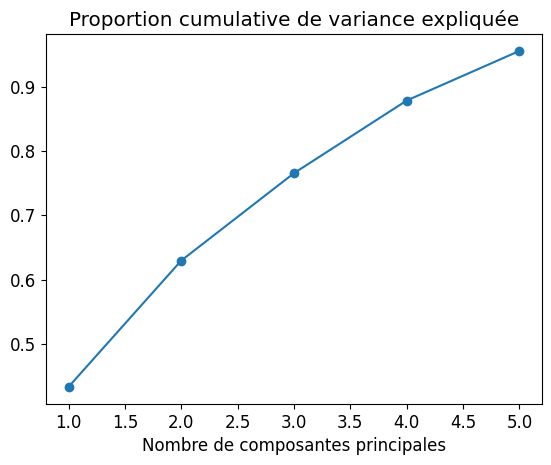

In [63]:
np.cumsum(pca_bis.explained_variance_ratio_)

plt.plot(np.arange(1, 6), np.cumsum(pca_bis.explained_variance_ratio_), marker='o')

plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")

On voit ici que la proportion cumulative de variance expliquée s'approche de 1.0 lorsqu'il y a 5 composantes principales, cela montre que réduire la dimension à 5 était une bonne chose

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

Ici on garde le même programme que précédemment en changeant simplement les données en entrée.

Le meilleur nombre d'arbres est : 10
La valeur de précision équilibrée correspondante est : 0.73


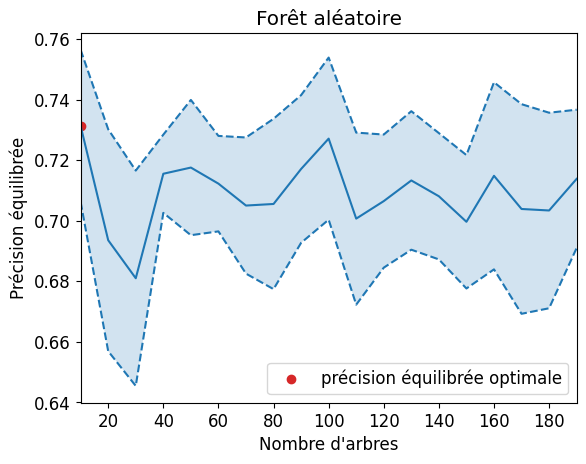

In [64]:
std_scale=preprocessing.StandardScaler().fit(X_projected)
X_projected_scaled = std_scale.transform(X_projected)

n_trees = np.arange(10, 200, 10)
forest_projected=ensemble.RandomForestClassifier()
grid_forest_projected=model_selection.GridSearchCV(forest_projected, {'n_estimators' : n_trees}, cv=5, scoring = 'balanced_accuracy')

grid_forest_projected.fit(X_projected_scaled, y_train_risk_vs_norisk)

balanced_accuracy = grid_forest_projected.cv_results_['mean_test_score']
std_error = grid_forest_projected.cv_results_['std_test_score']

plt.plot(grid_forest_projected.cv_results_['param_n_estimators'], balanced_accuracy, 
             label="", color='tab:blue')
plt.plot(grid_forest_projected.cv_results_['param_n_estimators'], balanced_accuracy + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_forest_projected.cv_results_['param_n_estimators'], balanced_accuracy - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_forest_projected.cv_results_['param_n_estimators'], (balanced_accuracy + std_error), (balanced_accuracy - std_error), 
                 alpha=0.2 
                )
plt.scatter(grid_forest_projected.best_params_['n_estimators'], grid_forest_projected.best_score_, 
           color='tab:red', label='précision équilibrée optimale')


plt.xlabel("Nombre d'arbres")
plt.ylabel("Précision équilibrée")
plt.xlim([n_trees[0], n_trees[-1]])
plt.title("Forêt aléatoire")
plt.legend(loc='best')

print(f"Le meilleur nombre d'arbres est : {grid_forest_projected.best_params_['n_estimators']}")
print(f"La valeur de précision équilibrée correspondante est : {grid_forest_projected.best_score_:.2f}")

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

On voit qu'en perdant de l'information (on a perdu une variable), on a perdu7 points de pourcentage en précision équilibrée, 1min de temps de calcul sur mon appareil et le nombre d'arbres à l'optimum est passé de 117 à 100. Ainsi, cette réduction de dimension ne semble pas si utile (notamment pour les pertes en précision équilibrée) même si cela permet de gagner du temps de calcul.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

L'algorithme en question est la forêt aléatoire

In [65]:
final_binary_classifier = ensemble.RandomForestClassifier()

grid_forest_bis=model_selection.GridSearchCV(final_binary_classifier, {'n_estimators' : n_trees}, cv=5, scoring = 'balanced_accuracy')

final_binary_classifier.fit(X_n_train_scaled, y_n_train)
y_n_test_pred = final_binary_classifier.predict(X_n_test_scaled)

print (f'La précision équilibrée est de {metrics.balanced_accuracy_score(y_n_test,y_n_test_pred):.2f}')

La précision équilibrée est de 0.83


### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [66]:
df_res= pd.read_csv("data/donnees_reservees.csv")
df_res_risk_vs_norisk = df_res.copy()
df_res_risk_vs_norisk['Risque'] = np.where(df_res['Risque']==2, 1, df_res['Risque'])

# Puis on crée l'étiquette et le jeu de données pour la suite
y_res_risk_vs_norisk = np.array(df_res_risk_vs_norisk['Risque'], dtype='int')

X_res_risk_vs_norisk = np.array(df_res_risk_vs_norisk.drop(columns=['Risque']))

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [67]:
std_scale = preprocessing.StandardScaler().fit(X_res_risk_vs_norisk)
X_res_risk_vs_norisk_scaled = std_scale.transform(X_res_risk_vs_norisk)

In [68]:
y_res_risk_vs_norisk_scaled_pred = final_binary_classifier.predict(X_res_risk_vs_norisk_scaled)

print (f'Le score est de {metrics.balanced_accuracy_score(y_res_risk_vs_norisk,y_res_risk_vs_norisk_scaled_pred):.2f}')

Le score est de 0.80


### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

On obtient sur ce modèle une précision équilibrée de 0.80, ce qui est légèrement moins (0.83) que ce que l'on a obtenu pour le jeu de données précédent. Les variables sont censées représenter les mêmes grandeurs, on doit donc trouver une explication : 

    - Cela peut être dû à la plage de valeur prise par les différentes variables du premier jeu de données : si celle-ci est plus petite que celle du second jeu, cela peut expliquer une certaine erreur liée à un manque d'entraînement de notre modèle sur certaines zones de valeurs pouvant être prises par nos variables. 

    - On peut également penser à un léger surentraînement, même si ici l'écart entre les deux précisions équilibrées obtenues reste tout de même faible

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

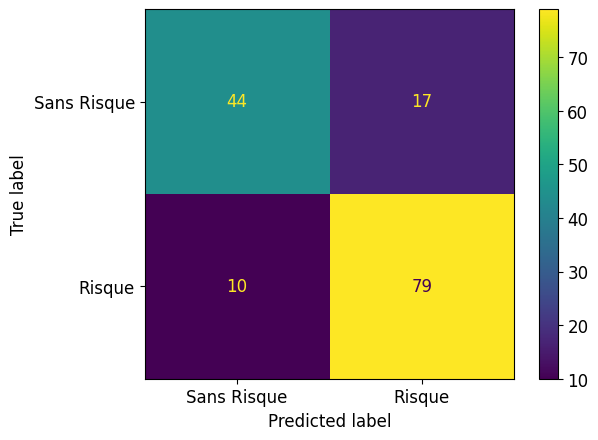

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix=metrics.confusion_matrix(y_res_risk_vs_norisk, y_res_risk_vs_norisk_scaled_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Sans Risque','Risque']).plot()
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

Ici, il faut surtout se pencher sur les personnes à risque (car si beaucoup de femmes doivent avoir un suivi médical sans être à risque, ça n'est pas si grave car il n'y aura aucune conséquence sur la santé de la femme). 
On voit ici que 10 femmes sont détectées sans risque sur les 89 étant un risque. Le ratio 10/89 semble bien important pour pouvoir considérer ce classifieur comme une référence.

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

L'algorithme KNN et celui de la forêt aléatoire peuvent être utilisés pour un classifieur multiclasse. De même pour l'arbre de décision (même si le côté robuste n'est pas le même que pour la forêt aléatoire). Une régression logistique pourrait également fonctionner mais étant donné les difficultés rencontrées en binaire, une étude en multiclasse avec une régression logistique semble limité

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

C'est parti pour le KNN !

La meilleure valeur de K est : 12
La précision équilibrée pour ce K vaut : 0.66


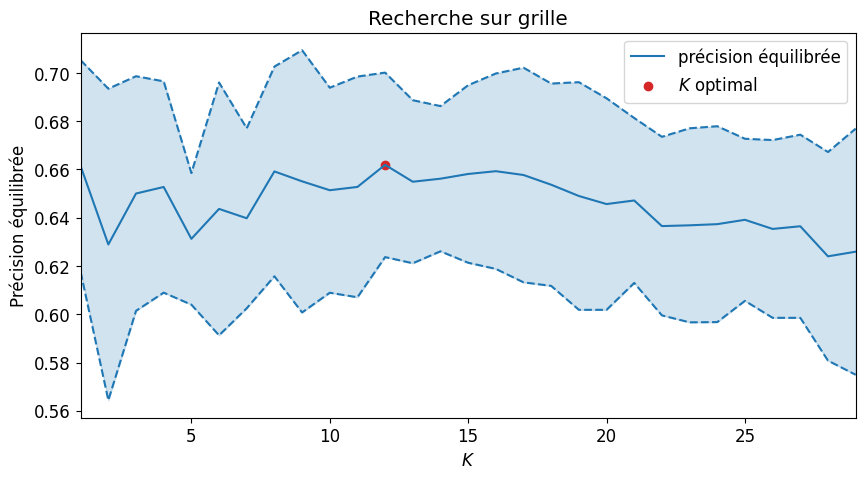

In [70]:
ks = np.arange(1, 30, 1)
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=30)
knn = KNeighborsClassifier()
grid_knn = model_selection.GridSearchCV(knn, {'n_neighbors':ks}, cv=kf, scoring='balanced_accuracy')
grid_knn.fit(X_train_scaled, y_train) 

plt.figure(figsize=(10,5))

balanced_acc = grid_knn.cv_results_['mean_test_score']
std_error = grid_knn.cv_results_['std_test_score']

plt.plot(grid_knn.cv_results_['param_n_neighbors'], balanced_acc, 
             label="précision équilibrée", color='tab:blue')
plt.plot(grid_knn.cv_results_['param_n_neighbors'], balanced_acc + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_knn.cv_results_['param_n_neighbors'], balanced_acc - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(ks, (balanced_acc - std_error), (balanced_acc + std_error), color='tab:blue', alpha=0.2)

plt.scatter(grid_knn.best_params_['n_neighbors'], grid_knn.best_score_, color='tab:red', label='$K$ optimal')

plt.xlabel("$K$")
plt.ylabel("Précision équilibrée")
plt.xlim(ks[0], ks[-1])
plt.title("Recherche sur grille")
plt.legend(loc='best')

print(f"La meilleure valeur de K est : {grid_knn.best_params_['n_neighbors']}")
print(f"La précision équilibrée pour ce K vaut : {grid_knn.best_score_:.2f}")

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

0.7344039255046281


Text(0.5, 1.0, 'Matrice de confusion avec classifieur mutliclasse')

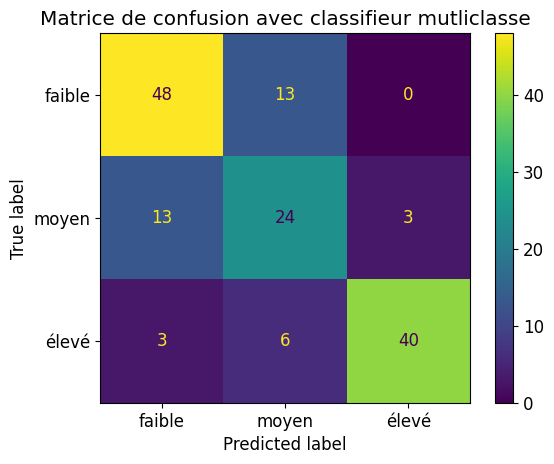

In [74]:
final_classifier = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'])

final_classifier.fit(X_train_scaled, y_train)

y_res = np.array(df_res['Risque'], dtype='int')

y_pred_res = final_classifier.predict(X_res_risk_vs_norisk_scaled)
pe_res_multi = metrics.balanced_accuracy_score(y_res, y_pred_res)
print(pe_res_multi)

matrice = metrics.ConfusionMatrixDisplay.from_predictions(y_res, y_pred_res, display_labels=['faible', 'moyen', 'élevé'])

plt.title("Matrice de confusion avec classifieur mutliclasse")


Nous voyons que la précision équilibrée est très bonne, meilleure que celle obtenue en Q29 par exemple. On peut également voir que les personnes à risques élevées sont bien détectées par notre classifieur. Cela fait référence à ce qui a été observé au début de notre étude : les classes "risque valant 0 ou 1" et "risque valant 2" semblent plus simple à distinguer. La détection des personnes à risque moyen semble être le point faible de notre algorithme... 

Le classifieur développé peut être intéressant pour détecter les personnes à risque élevé mais semble encore trop peu efficace et pas assez fiable étant donné le contexte d'application pour les personnes à risque moyen